In [1]:
#importing libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

## Read in images and create a dataframe of image paths and class labels

In [2]:
train_dir=r'../input/leaf-disease-detection-dataset/dataset/train'
test_dir=r'../input/leaf-disease-detection-dataset/dataset/test'
for d in [train_dir, test_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])   
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  test_df length: ', len(test_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  63265   test_df length:  7030   test_df length:  7030
The number of classes in the dataset is:  21
            CLASS               IMAGE COUNT 
         _Apple_scab               1814     
       _Bacterial_spot             4908     
          _Black_rot               3487     
      _Cedar_apple_rust            1584     
_Cercospora_leaf_spot Gray_leaf_spot     1478     
        _Common_rust_              1716     
        _Early_blight              3473     
    _Esca_(Black_Measles)          1728     
_Haunglongbing_(Citrus_greening)     1809     
         _Late_blight              3411     
          _Leaf_Mold               1694     
_Leaf_blight_(Isariopsis_Leaf_Spot)     1550     
         _Leaf_scorch              1597     
    _Northern_Leaf_Blight          1717     
       _Powdery_mildew             3077     
     _Septoria_leaf_spot           1571     
_Spider_mites Two-spotted_spider_mite     1567     
         _Target_Spot              1644     
_Tomato_

**Create the train_gen, test_gen**

In [3]:
train_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set=train_gen.flow_from_directory(train_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

test_set=test_gen.flow_from_directory(test_dir,
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


**Create a function to show example training images**

Images for Training......................


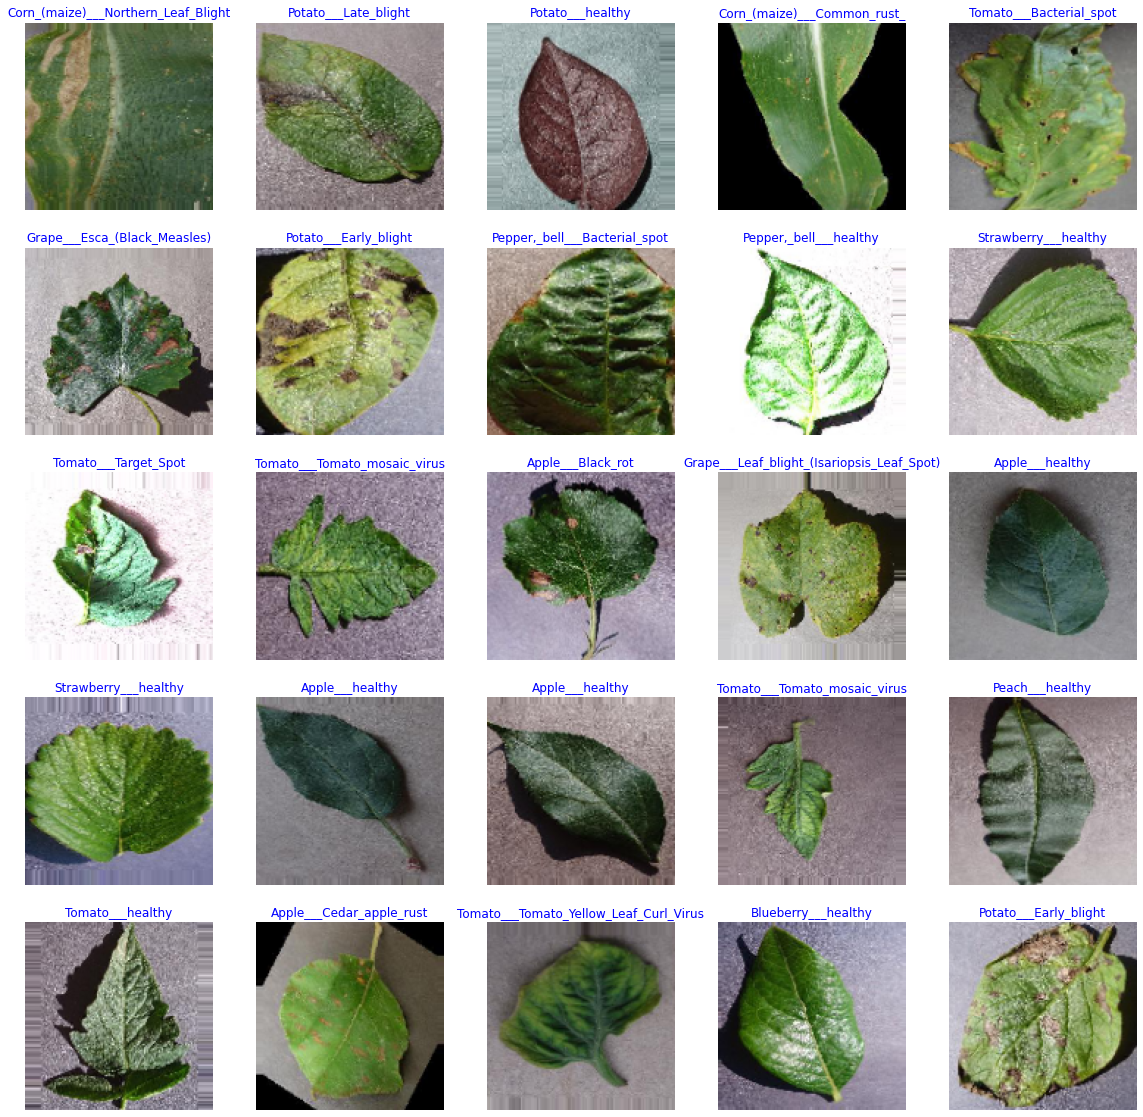

Images for Testing.......................


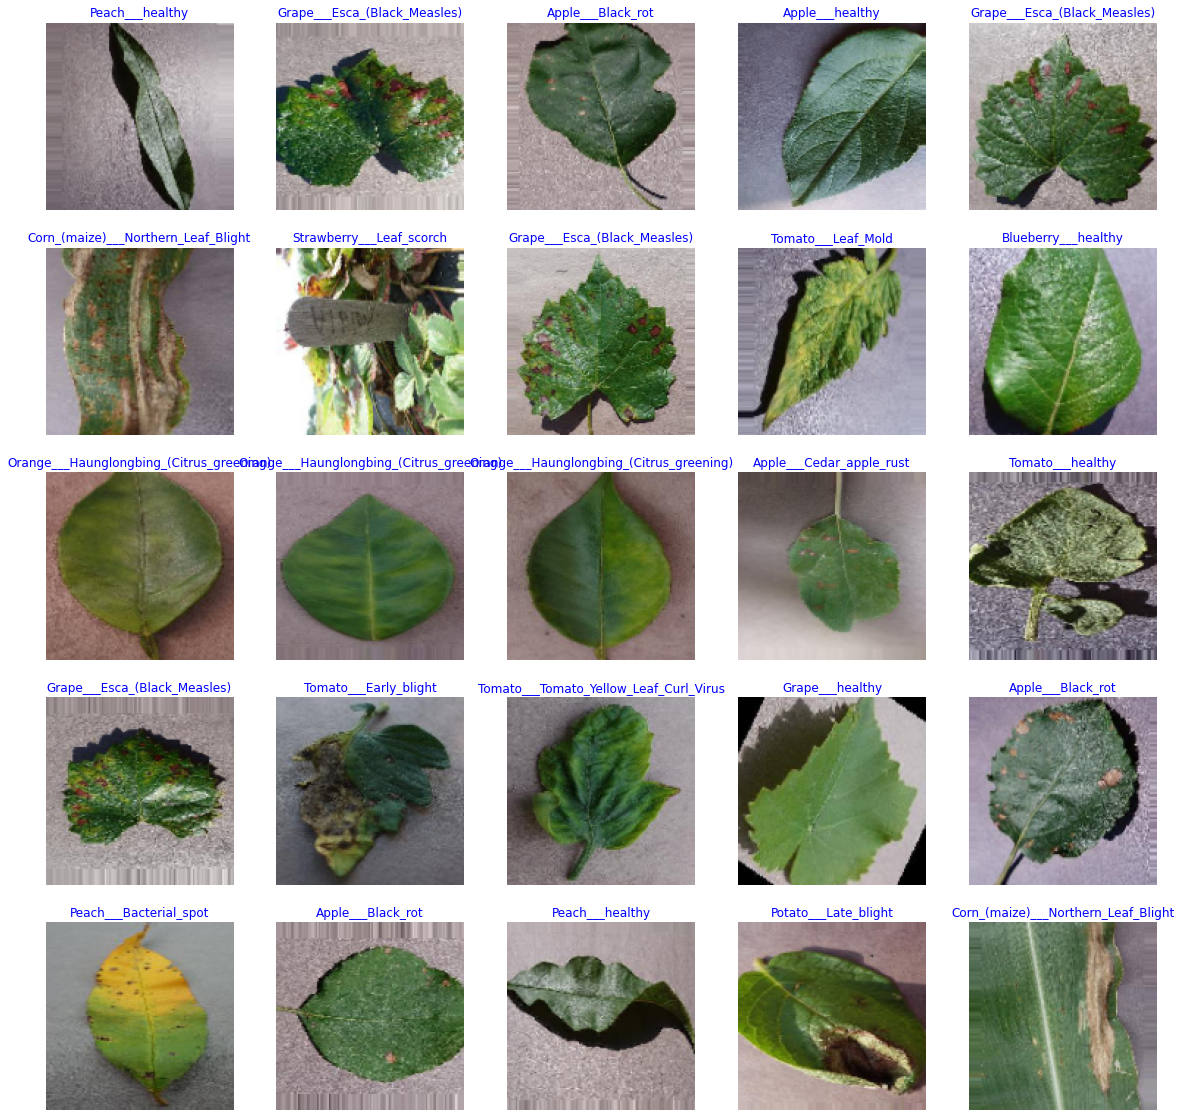

In [4]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
print("Images for Training......................")
show_image_samples(training_set )
print("Images for Testing.......................")
show_image_samples(test_set )

## Convolutional Neural Network

In [5]:
#basic cnn layers
model = Sequential()
model.add(Conv2D(32, kernel_size= (3,3), activation = 'relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(96,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size= (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size =(2,2,)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(38, activation = 'softmax'))
#compiling our model 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

## ModelTraining

In [6]:
labels=(training_set.class_indices)
labels2=(test_set.class_indices)
#fitting data into our model
fitted_model = model.fit(training_set,
                    steps_per_epoch=375,
                    epochs=10,
                    validation_data = test_set,
                    validation_steps = 125)

Epoch 1/10
375/375 [==============================] - 128s 322ms/step - loss: 2.5198 - accuracy: 0.2972 - val_loss: 2.0965 - val_accuracy: 0.4142
Epoch 2/10
375/375 [==============================] - 111s 297ms/step - loss: 1.5966 - accuracy: 0.5213 - val_loss: 1.6618 - val_accuracy: 0.4918
Epoch 3/10
375/375 [==============================] - 105s 281ms/step - loss: 1.2858 - accuracy: 0.6037 - val_loss: 1.2162 - val_accuracy: 0.6112
Epoch 4/10
375/375 [==============================] - 102s 271ms/step - loss: 1.0625 - accuracy: 0.6720 - val_loss: 1.4576 - val_accuracy: 0.5527
Epoch 5/10
375/375 [==============================] - 100s 266ms/step - loss: 0.9129 - accuracy: 0.7126 - val_loss: 0.8477 - val_accuracy: 0.7410
Epoch 6/10
375/375 [==============================] - 96s 257ms/step - loss: 0.7942 - accuracy: 0.7499 - val_loss: 0.6045 - val_accuracy: 0.8160
Epoch 7/10
375/375 [==============================] - 94s 251ms/step - loss: 0.7130 - accuracy: 0.7728 - val_loss: 0.6744 - v

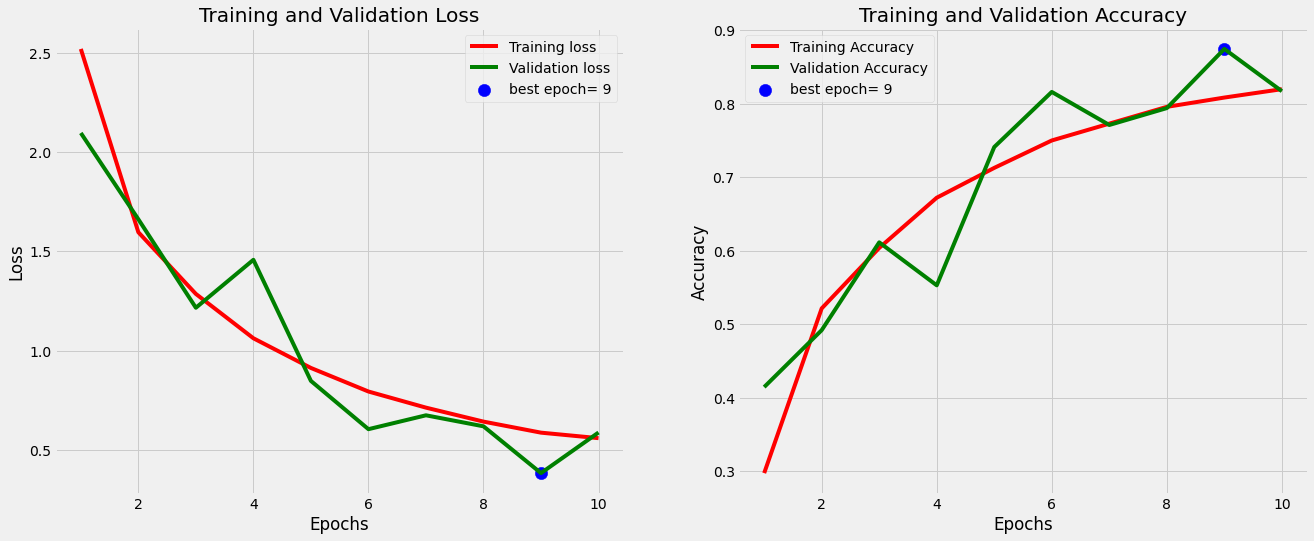

In [7]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(fitted_model,0)

## Model Evaluation

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        3

In [9]:
#Label assignment
label=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
       'Blueberry___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_',
       'Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot','Grape___Esca_(Black_Measles)',
       'Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot',
       'Peach___healthy','Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight',
       'Potato___healthy','Potato___Late_blight','Raspberry___healthy','Soybean___healthy',
       'Squash___Powdery_mildew','Strawberry___healthy','Strawberry___Leaf_scorch','Tomato___Bacterial_spot',
       'Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight','Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
       'Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']

# Predicting Output

In [10]:
#path=input("Enter your image path-: ")
def testing(path):
    test_image=image.load_img(path,target_size=(128,128))
    #print(test_image)
    test_image=image.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result = model.predict(test_image)

    #print(f"Result is --> {result}")
    fresult=np.max(result)
    label2=label[result.argmax()]
    print(f"your leaf disease is --> {label2}")
#testing(input("Enter your image path-: "))
path='../input/leaf-disease-detection-dataset/images_for_test/CornCommonRust2.JPG'
testing(path)

your leaf disease is --> Corn_(maize)___Common_rust_



* **If you find this helpful, I would really appreciate the upvote!**

* **If you see something wrong please let me know.**

* **And lastly Im happy to hear your thoughts about the notebook for me to also improve!**